In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//346.json"))

pixscale = 0.2 # arcsec
pixscale *= 0.3               # parsec
s0 = (0.3*.9)/2.355              # parsec
m = 1.05

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

(31.87910585532852, 1.3585371476368509)

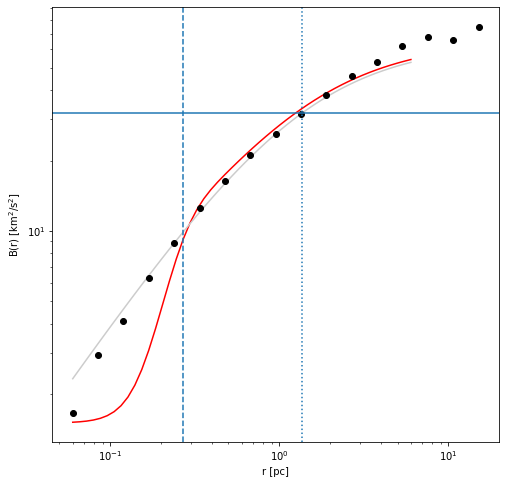

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline( 2.355  * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2,r0

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.05
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 4.0
weights[0] /= 2.0
weights[1] /= 8.0
weights[2] /= 4.0
weights[3] /= 2.0

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.05)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1, sig2=sig2
)

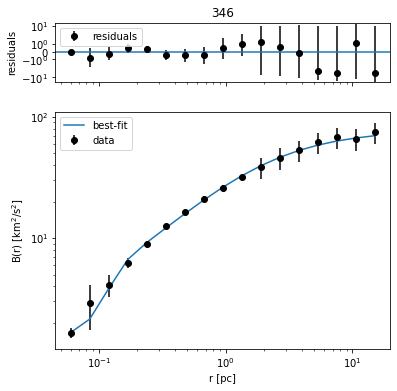

In [10]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title='346',
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('SFpaper//346.pdf', bbox_inches='tight')


In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 17
    # variables        = 5
    chi-square         = 3.26907891
    reduced chi-square = 0.27242324
    Akaike info crit   = -18.0279863
    Bayesian info crit = -13.8619196
[[Variables]]
    r0:     1.89839751 +/- 0.27580664 (14.53%) (init = 1.358537)
    sig2:   38.0113392 +/- 3.09754140 (8.15%) (init = 31.87911)
    m:      1.05636520 +/- 0.04075432 (3.86%) (init = 1.05)
    s0:     0.05953248 +/- 0.00480151 (8.07%) (init = 0.1146497)
    noise:  1.54360325 +/- 0.09998085 (6.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2)  =  0.972
    C(r0, m)     = -0.894
    C(sig2, m)   = -0.790
    C(s0, noise) =  0.472
    C(m, s0)     = -0.314
    C(r0, s0)    =  0.251
    C(sig2, s0)  =  0.190


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.027227427879673836 < 1e-05 at iteration 5 and prob(s0=0.03552490959708537) = 0.8868107395930582 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.00029166492962208674 < 1e-05 at iteration 5 and prob(noise=1.043699004468356) = 0.9107496282471003 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.79707  -0.53740  -0.28059   1.89840  +0.35141  +0.87692  +1.88368
 sig2 : -10.33414  -6.59472  -3.27745  38.01134  +3.69179  +8.54528 +16.27148
 m    :  -0.15937  -0.09520  -0.04508   1.05637  +0.04668  +0.10274  +0.18184
 s0   :      -inf      -inf  -0.00803   0.05953  +0.00673  +0.01357  +0.02208
 noise:      -inf      -inf  -0.13091   1.54360  +0.11084  +0.22904  +0.37572


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [0.85, 1.4],
    "r0": [1, 2],
    "noise": [1, 2.5],
    "sig2": [34, 45],

}

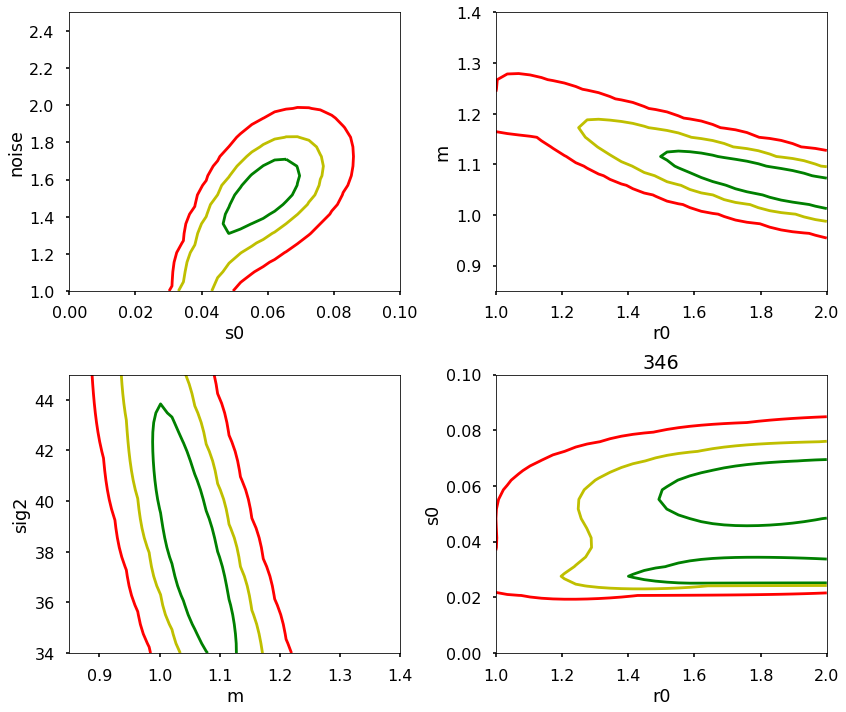

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('346')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "sig2"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
x=r
y=B-2*sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([5.78897679])

In [18]:
r.max()/result2.params['r0'].value

7.938968783379192

In [19]:
(r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))

0.42889657987906576

In [20]:
#f = open('CI//346.pkl',"wb")
#pickle.dump(result2,f)
#f.close()

In [21]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 25.811218976974487 seconds ---
